In [1]:
from analysis_tools import*

# Specify the metrics to use
zeroshot_metrics = ['zeroshot-val-top1']
retrieval_metrics = ['image_to_text_R@{}', 'text_to_image_R@{}'] # Format paths 

# Specify the datasets to use
zeroshot_datasets = ['ILT-CLS']
retrieval_datasets = ['ILT']

base_fontsize = 24

# Specify the paths of the (text!) files in which the results are stored 
validation_path = './results/eval_ilt.txt'
test_path = './results/test_eval_ilt.txt'

epochs_dict = {'baseline': [0, 5], 'basic-al': [5], 'probvlm': [10], 
                  's-clip': [5], 'soft-pl': [5], 'hard-pl': [5],}

# Hyperparameter tuning results

In [2]:
df_grouped = prep_and_store_results(validation_path)

Number of evaluations: 11375
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,52.17,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
1,ILT,image_to_text_R@1,34.78,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
2,ILT,image_to_text_R@5,86.96,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
3,ILT,image_to_text_R@10,95.65,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
4,ILT,text_to_image_R@1,39.13,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
...,...,...,...,...,...,...,...,...,...,...,...,...
11370,ILT,image_to_text_R@5,56.52,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4
11371,ILT,image_to_text_R@10,95.65,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4
11372,ILT,text_to_image_R@1,34.78,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4
11373,ILT,text_to_image_R@5,69.57,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,52.17,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
1,ILT,image_to_text_R@1,34.78,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
2,ILT,image_to_text_R@5,86.96,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
3,ILT,image_to_text_R@10,95.65,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
4,ILT,text_to_image_R@1,39.13,0.2,base,False,NaN,NaN,None,5,5.000000e-07,8
...,...,...,...,...,...,...,...,...,...,...,...,...
11370,ILT,image_to_text_R@5,56.52,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4
11371,ILT,image_to_text_R@10,95.65,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4
11372,ILT,text_to_image_R@1,34.78,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4
11373,ILT,text_to_image_R@5,69.57,0.2,base,True,10.0,10.0,None,25,5.000000e-06,4


value  \
                                                                                                     mean   
epochs dataset PL        AL.iter bs AL.epochs lr       metric             ratio ProbVLM method              
5      ILT     None      10.0    4  10.0      0.000005 image_to_text_R@1  0.2   True    base    30.433333   
                                                       image_to_text_R@10 0.2   True    base    89.853333   
                                                       image_to_text_R@5  0.2   True    base    68.116667   
                                                       text_to_image_R@1  0.2   True    base    37.680000   
                                                       text_to_image_R@10 0.2   True    base    86.956667   
...                                                                                                   ...   
30     ILT-CLS soft.text NaN     8  NaN       0.000050 zeroshot-val-top1  0.2   False   ours    34.783333   
                                              0.000500 zeroshot-val-top1  0.2   False   ours    20.290000   
                                 16 NaN       0.000005 zeroshot-val-top1  0.2   False   ours    21.740000   
                                              0.000050 zeroshot-val-top1  0.2   False   ours    34.780000   
                                              0.000500 zeroshot-val-top1  0.2   False   ours    27.533333   

                                                                                                           \
                                                                                                      std   
epochs dataset PL        AL.iter bs AL.epochs lr       metric             ratio ProbVLM method              
5      ILT     None      10.0    4  10.0      0.000005 image_to_text_R@1  0.2   True    base     4.345001   
                                                       image_to_text_R@10 0.2   True    base     2.505700   
                                                       image_to_text_R@5  0.2   True    base     5.017174   
                                                       text_to_image_R@1  0.2   True    base     6.644735   
                                                       text_to_image_R@10 0.2   True    base     4.345001   
...                                                                                                   ...   
30     ILT-CLS soft.text NaN     8  NaN       0.000050 zeroshot-val-top1  0.2   False   ours     7.528648   
                                              0.000500 zeroshot-val-top1  0.2   False   ours     6.644735   
                                 16 NaN       0.000005 zeroshot-val-top1  0.2   False   ours     0.000000   
                                              0.000050 zeroshot-val-top1  0.2   False   ours    19.924385   
                                              0.000500 zeroshot-val-top1  0.2   False   ours     5.017174   

                                                                                                      \
                                                                                               count   
epochs dataset PL        AL.iter bs AL.epochs lr       metric             ratio ProbVLM method         
5      ILT     None      10.0    4  10.0      0.000005 image_to_text_R@1  0.2   True    base       3   
                                                       image_to_text_R@10 0.2   True    base       3   
                                                       image_to_text_R@5  0.2   True    base       3   
                                                       text_to_image_R@1  0.2   True    base       3   
                                                       text_to_image_R@10 0.2   True    base       3   
...                                                                                              ...   
30     ILT-CLS soft.text NaN     8  NaN       0.000050 zeroshot-val-top1  0.2   False   ours       3   
      

In [3]:
df_results = df_grouped.reset_index()
# We fill NaN values in the AL.epochs column to avoid issues with dropping rows with NaNs
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

epochs  dataset         PL AL.iter  bs AL.epochs            lr  \
                                                                      
1615     20      ILT       None     NaN   8      20.0  5.000000e-04   
617      10      ILT       None     NaN   8      10.0  5.000000e-04   
2585     30      ILT       None    10.0   4       5.0  5.000000e-04   
240       5      ILT   ot.image     NaN   4       5.0  5.000000e-05   
731      10      ILT  hard.text     NaN   8      10.0  5.000000e-04   
...     ...      ...        ...     ...  ..       ...           ...   
3729     30  ILT-CLS       None     NaN  16      30.0  5.000000e-04   
993      10  ILT-CLS       None    20.0  16       5.0  5.000000e-06   
475       5  ILT-CLS       None     NaN   8       5.0  5.000000e-06   
474       5  ILT-CLS       None     NaN   8       5.0  5.000000e-07   
476       5  ILT-CLS       None     NaN   8       5.0  5.000000e-05   

                 metric ratio ProbVLM method      value                      \
                                                   mean           std count   
1615  image_to_text_R@1   0.2   False   base   0.000000  0.000000e+00     3   
617   image_to_text_R@1   0.2   False   base   1.450000  2.511474e+00     3   
2585  image_to_text_R@1   0.2   False   base   1.450000  2.511474e+00     3   
240   image_to_text_R@1   0.2   False   ours   2.900000  2.511474e+00     3   
731   image_to_text_R@1   0.2   False   ours   2.900000  2.511474e+00     3   
...                 ...   ...     ...    ...        ...           ...   ...   
3729  zeroshot-val-top1   0.2   False   base  52.170000  8.702336e-15     3   
993   zeroshot-val-top1   0.2   False   base  52.170000  0.000000e+00     2   
475   zeroshot-val-top1   0.2   False   base  52.173333  4.345001e+00     3   
474   zeroshot-val-top1   0.2   False   base  53.257500  2.175000e+00     4   
476   zeroshot-val-top1   0.2   False   base  55.070000  2.511474e+00     3   

                                                  
                               all    min    max  
1615               [0.0, 0.0, 0.0]   0.00   0.00  
617               [0.0, 0.0, 4.35]   0.00   4.35  
2585              [0.0, 0.0, 4.35]   0.00   4.35  
240              [4.35, 0.0, 4.35]   0.00   4.35  
731              [4.35, 4.35, 0.0]   0.00   4.35  
...                            ...    ...    ...  
3729         [52.17, 52.17, 52.17]  52.17  52.17  
993                 [52.17, 52.17]  52.17  52.17  
475          [52.17, 56.52, 47.83]  47.83  56.52  
474   [56.52, 52.17, 52.17, 52.17]  52.17  56.52  
476          [56.52, 52.17, 56.52]  52.17  56.52  

[3787 rows x 17 columns]

In [4]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_method(df_results, label_ratio = 0.2)

#Loop over the methods to show the tuning results
for method in results_dict:
    print(method)
    df_method = results_dict[method].groupby(['metric', 'dataset'])
    full_display(df_method.tail(5))

baseline


epochs  dataset    PL AL.iter  bs AL.epochs            lr  \
                                                                 
2136     25      ILT  None     NaN  16      25.0  5.000000e-04   
3245     30      ILT  None     NaN  16      30.0  5.000000e-07   
3251     30      ILT  None     NaN  16      30.0  5.000000e-06   
3257     30      ILT  None     NaN  16      30.0  5.000000e-05   
3263     30      ILT  None     NaN  16      30.0  5.000000e-04   
2137     25      ILT  None     NaN  16      25.0  5.000000e-04   
3246     30      ILT  None     NaN  16      30.0  5.000000e-07   
3252     30      ILT  None     NaN  16      30.0  5.000000e-06   
3258     30      ILT  None     NaN  16      30.0  5.000000e-05   
3264     30      ILT  None     NaN  16      30.0  5.000000e-04   
3259     30      ILT  None     NaN  16      30.0  5.000000e-05   
3265     30      ILT  None     NaN  16      30.0  5.000000e-04   
80        5      ILT  None     NaN   8       5.0  5.000000e-06   
601      10      ILT  None     NaN   8      10.0  5.000000e-07   
86        5      ILT  None     NaN   8       5.0  5.000000e-05   
2139     25      ILT  None     NaN  16      25.0  5.000000e-04   
3248     30      ILT  None     NaN  16      30.0  5.000000e-07   
3254     30      ILT  None     NaN  16      30.0  5.000000e-06   
3260     30      ILT  None     NaN  16      30.0  5.000000e-05   
3266     30      ILT  None     NaN  16      30.0  5.000000e-04   
2140     25      ILT  None     NaN  16      25.0  5.000000e-04   
3249     30      ILT  None     NaN  16      30.0  5.000000e-07   
3255     30      ILT  None     NaN  16      30.0  5.000000e-06   
3261     30      ILT  None     NaN  16      30.0  5.000000e-05   
3267     30      ILT  None     NaN  16      30.0  5.000000e-04   
3256     30      ILT  None     NaN  16      30.0  5.000000e-06   
3262     30      ILT  None     NaN  16      30.0  5.000000e-05   
3268     30      ILT  None     NaN  16      30.0  5.000000e-04   
83        5      ILT  None     NaN   8       5.0  5.000000e-06   
77        5      ILT  None     NaN   8       5.0  5.000000e-07   
3728     30  ILT-CLS  None     NaN  16      30.0  5.000000e-05   
3729     30  ILT-CLS  None     NaN  16      30.0  5.000000e-04   
475       5  ILT-CLS  None     NaN   8       5.0  5.000000e-06   
474       5  ILT-CLS  None     NaN   8       5.0  5.000000e-07   
476       5  ILT-CLS  None     NaN   8       5.0  5.000000e-05   

                  metric ratio ProbVLM method      value                      \
                                                    mean           std count   
2136   image_to_text_R@1   0.2   False   base  43.480000  0.000000e+00     3   
3245   image_to_text_R@1   0.2   False   base  43.480000  0.000000e+00     3   
3251   image_to_text_R@1   0.2   False   base  43.480000  0.000000e+00     3   
3257   image_to_text_R@1   0.2   False   base  43.480000  0.000000e+00     3   
3263   image_to_text_R@1   0.2   False   base  43.480000  0.000000e+00     3   
2137  image_to_text_R@10   0.2   False   base  95.650000  1.740467e-14     3   
3246  image_to_text_R@10   0.2   False   base  95.650000  1.740467e-14     3   
3252  image_to_text_R@10   0.2   False   base  95.650000  1.740467e-14     3   
3258  image_to_text_R@10   0.2   False   base  95.650000  1.740467e-14     3   
3264  image_to_text_R@10   0.2   False   base  95.650000  1.740467e-14     3   
3259   image_to_text_R@5   0.2   False   base  86.960000  0.000000e+00     3   
3265   image_to_text_R@5   0.2   False   base  86.960000  0.000000e+00     3   
80     image_to_text_R@5   0.2   False   base  88.406667  2.505700e+00     3   
601    image_to_text_R@5   0.2   False   base  89.130000  2.505700e+00     4   
86     image_to_text_R@5   0.2   False   base  91.303333  4.345001e+00     3   
2139   text_to_image_R@1   0.2   False   base  56.520000  0.000000e+00     3   
3248   text_to_image_R@1   0.2   False   base  56.520000  0.000000e+00     3   
3254   text_to_image_R@1   0.2   False   b

s-clip


epochs  dataset        PL AL.iter  bs AL.epochs        lr  \
                                                                 
288       5      ILT  ot.image     NaN  16       5.0  0.000050   
294       5      ILT  ot.image     NaN  16       5.0  0.000500   
336       5      ILT   ot.text     NaN  16       5.0  0.000005   
342       5      ILT   ot.text     NaN  16       5.0  0.000050   
348       5      ILT   ot.text     NaN  16       5.0  0.000500   
289       5      ILT  ot.image     NaN  16       5.0  0.000050   
295       5      ILT  ot.image     NaN  16       5.0  0.000500   
337       5      ILT   ot.text     NaN  16       5.0  0.000005   
343       5      ILT   ot.text     NaN  16       5.0  0.000050   
349       5      ILT   ot.text     NaN  16       5.0  0.000500   
290       5      ILT  ot.image     NaN  16       5.0  0.000050   
296       5      ILT  ot.image     NaN  16       5.0  0.000500   
338       5      ILT   ot.text     NaN  16       5.0  0.000005   
344       5      ILT   ot.text     NaN  16       5.0  0.000050   
350       5      ILT   ot.text     NaN  16       5.0  0.000500   
327       5      ILT   ot.text     NaN   8       5.0  0.000050   
333       5      ILT   ot.text     NaN   8       5.0  0.000500   
764      10      ILT  ot.image     NaN   4      10.0  0.000005   
830      10      ILT   ot.text     NaN   4      10.0  0.000005   
1313     15      ILT  ot.image     NaN  16      15.0  0.000005   
292       5      ILT  ot.image     NaN  16       5.0  0.000050   
298       5      ILT  ot.image     NaN  16       5.0  0.000500   
340       5      ILT   ot.text     NaN  16       5.0  0.000005   
346       5      ILT   ot.text     NaN  16       5.0  0.000050   
352       5      ILT   ot.text     NaN  16       5.0  0.000500   
293       5      ILT  ot.image     NaN  16       5.0  0.000050   
299       5      ILT  ot.image     NaN  16       5.0  0.000500   
341       5      ILT   ot.text     NaN  16       5.0  0.000005   
347       5      ILT   ot.text     NaN  16       5.0  0.000050   
353       5      ILT   ot.text     NaN  16       5.0  0.000500   
510       5  ILT-CLS  ot.image     NaN  16       5.0  0.000050   
511       5  ILT-CLS  ot.image     NaN  16       5.0  0.000500   
518       5  ILT-CLS   ot.text     NaN  16       5.0  0.000005   
519       5  ILT-CLS   ot.text     NaN  16       5.0  0.000050   
520       5  ILT-CLS   ot.text     NaN  16       5.0  0.000500   

                  metric ratio ProbVLM method      value                  \
                                                    mean       std count   
288    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
294    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
336    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
342    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
348    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
289   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
295   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
337   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
343   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
349   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
290    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
296    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
338    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
344    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
350    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
327    text_to_image_R@1   0.2   False   ours  37.680000  2.511474     3   
333    text_to_image_R@1   0.2   False   ours  37.680000  2.511474     3   
764    text_to_image_R@1   0.2   False   ours  39.130000  0.000000     3   
830    text_to_image_R@1   0.2   False   o

soft-pl


epochs  dataset          PL AL.iter  bs AL.epochs        lr  \
                                                                   
396       5      ILT  soft.image     NaN  16       5.0  0.000050   
402       5      ILT  soft.image     NaN  16       5.0  0.000500   
444       5      ILT   soft.text     NaN  16       5.0  0.000005   
450       5      ILT   soft.text     NaN  16       5.0  0.000050   
456       5      ILT   soft.text     NaN  16       5.0  0.000500   
397       5      ILT  soft.image     NaN  16       5.0  0.000050   
403       5      ILT  soft.image     NaN  16       5.0  0.000500   
445       5      ILT   soft.text     NaN  16       5.0  0.000005   
451       5      ILT   soft.text     NaN  16       5.0  0.000050   
457       5      ILT   soft.text     NaN  16       5.0  0.000500   
398       5      ILT  soft.image     NaN  16       5.0  0.000050   
404       5      ILT  soft.image     NaN  16       5.0  0.000500   
446       5      ILT   soft.text     NaN  16       5.0  0.000005   
452       5      ILT   soft.text     NaN  16       5.0  0.000050   
458       5      ILT   soft.text     NaN  16       5.0  0.000500   
2379     25      ILT  soft.image     NaN   4      25.0  0.000005   
884      10      ILT  soft.image     NaN   4      10.0  0.000005   
1475     15      ILT   soft.text     NaN  16      15.0  0.000005   
3596     30      ILT   soft.text     NaN  16      30.0  0.000005   
1421     15      ILT  soft.image     NaN  16      15.0  0.000005   
454       5      ILT   soft.text     NaN  16       5.0  0.000050   
460       5      ILT   soft.text     NaN  16       5.0  0.000500   
1458     15      ILT   soft.text     NaN   8      15.0  0.000005   
3561     30      ILT   soft.text     NaN   4      30.0  0.000005   
1937     20      ILT   soft.text     NaN   4      20.0  0.000005   
401       5      ILT  soft.image     NaN  16       5.0  0.000050   
407       5      ILT  soft.image     NaN  16       5.0  0.000500   
449       5      ILT   soft.text     NaN  16       5.0  0.000005   
455       5      ILT   soft.text     NaN  16       5.0  0.000050   
461       5      ILT   soft.text     NaN  16       5.0  0.000500   
528       5  ILT-CLS  soft.image     NaN  16       5.0  0.000050   
529       5  ILT-CLS  soft.image     NaN  16       5.0  0.000500   
536       5  ILT-CLS   soft.text     NaN  16       5.0  0.000005   
537       5  ILT-CLS   soft.text     NaN  16       5.0  0.000050   
538       5  ILT-CLS   soft.text     NaN  16       5.0  0.000500   

                  metric ratio ProbVLM method      value                  \
                                                    mean       std count   
396    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
402    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
444    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
450    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
456    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
397   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
403   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
445   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
451   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
457   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
398    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
404    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
446    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
452    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
458    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
2379   text_to_image_R@1   0.2   False   ours  36.230000  6.644735     3   
884    text_to_image_R@1   0.2   False   ours  37.680000  5.022947     3   
1475   text_to_image_R@1   0.2   False   our

hard-pl


epochs  dataset          PL AL.iter  bs AL.epochs        lr  \
                                                                   
162       5      ILT  hard.image     NaN  16       5.0  0.000050   
168       5      ILT  hard.image     NaN  16       5.0  0.000500   
210       5      ILT   hard.text     NaN  16       5.0  0.000005   
216       5      ILT   hard.text     NaN  16       5.0  0.000050   
222       5      ILT   hard.text     NaN  16       5.0  0.000500   
163       5      ILT  hard.image     NaN  16       5.0  0.000050   
169       5      ILT  hard.image     NaN  16       5.0  0.000500   
211       5      ILT   hard.text     NaN  16       5.0  0.000005   
217       5      ILT   hard.text     NaN  16       5.0  0.000050   
223       5      ILT   hard.text     NaN  16       5.0  0.000500   
164       5      ILT  hard.image     NaN  16       5.0  0.000050   
170       5      ILT  hard.image     NaN  16       5.0  0.000500   
212       5      ILT   hard.text     NaN  16       5.0  0.000005   
218       5      ILT   hard.text     NaN  16       5.0  0.000050   
224       5      ILT   hard.text     NaN  16       5.0  0.000500   
1241     15      ILT   hard.text     NaN  16      15.0  0.000005   
2235     25      ILT   hard.text     NaN  16      25.0  0.000005   
3308     30      ILT  hard.image     NaN  16      30.0  0.000005   
2181     25      ILT  hard.image     NaN  16      25.0  0.000005   
1187     15      ILT  hard.image     NaN  16      15.0  0.000005   
166       5      ILT  hard.image     NaN  16       5.0  0.000050   
172       5      ILT  hard.image     NaN  16       5.0  0.000500   
214       5      ILT   hard.text     NaN  16       5.0  0.000005   
220       5      ILT   hard.text     NaN  16       5.0  0.000050   
226       5      ILT   hard.text     NaN  16       5.0  0.000500   
167       5      ILT  hard.image     NaN  16       5.0  0.000050   
173       5      ILT  hard.image     NaN  16       5.0  0.000500   
215       5      ILT   hard.text     NaN  16       5.0  0.000005   
221       5      ILT   hard.text     NaN  16       5.0  0.000050   
227       5      ILT   hard.text     NaN  16       5.0  0.000500   
489       5  ILT-CLS  hard.image     NaN  16       5.0  0.000050   
490       5  ILT-CLS  hard.image     NaN  16       5.0  0.000500   
497       5  ILT-CLS   hard.text     NaN  16       5.0  0.000005   
498       5  ILT-CLS   hard.text     NaN  16       5.0  0.000050   
499       5  ILT-CLS   hard.text     NaN  16       5.0  0.000500   

                  metric ratio ProbVLM method      value                  \
                                                    mean       std count   
162    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
168    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
210    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
216    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
222    image_to_text_R@1   0.2   False   ours  37.680000  2.511474     3   
163   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
169   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
211   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
217   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
223   image_to_text_R@10   0.2   False   ours  94.200000  2.511474     3   
164    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
170    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
212    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
218    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
224    image_to_text_R@5   0.2   False   ours  89.853333  2.505700     3   
1241   text_to_image_R@1   0.2   False   ours  36.230000  5.022947     3   
2235   text_to_image_R@1   0.2   False   ours  36.230000  2.511474     3   
3308   text_to_image_R@1   0.2   False   our

basic-al


epochs  dataset    PL AL.iter  bs AL.epochs        lr  \
                                                             
3137     30      ILT  None    20.0  16      10.0  0.000050   
3143     30      ILT  None    20.0  16      10.0  0.000500   
3149     30      ILT  None    20.0  16      15.0  0.000005   
3155     30      ILT  None    20.0  16      15.0  0.000050   
3161     30      ILT  None    20.0  16      15.0  0.000500   
3138     30      ILT  None    20.0  16      10.0  0.000050   
3144     30      ILT  None    20.0  16      10.0  0.000500   
3150     30      ILT  None    20.0  16      15.0  0.000005   
3156     30      ILT  None    20.0  16      15.0  0.000050   
3162     30      ILT  None    20.0  16      15.0  0.000500   
3139     30      ILT  None    20.0  16      10.0  0.000050   
3145     30      ILT  None    20.0  16      10.0  0.000500   
3151     30      ILT  None    20.0  16      15.0  0.000005   
3157     30      ILT  None    20.0  16      15.0  0.000050   
3163     30      ILT  None    20.0  16      15.0  0.000500   
3140     30      ILT  None    20.0  16      10.0  0.000050   
3146     30      ILT  None    20.0  16      10.0  0.000500   
3152     30      ILT  None    20.0  16      15.0  0.000005   
3158     30      ILT  None    20.0  16      15.0  0.000050   
3164     30      ILT  None    20.0  16      15.0  0.000500   
3141     30      ILT  None    20.0  16      10.0  0.000050   
3147     30      ILT  None    20.0  16      10.0  0.000500   
3153     30      ILT  None    20.0  16      15.0  0.000005   
3159     30      ILT  None    20.0  16      15.0  0.000050   
3165     30      ILT  None    20.0  16      15.0  0.000500   
3142     30      ILT  None    20.0  16      10.0  0.000050   
3148     30      ILT  None    20.0  16      10.0  0.000500   
3154     30      ILT  None    20.0  16      15.0  0.000005   
3160     30      ILT  None    20.0  16      15.0  0.000050   
3166     30      ILT  None    20.0  16      15.0  0.000500   
3709     30  ILT-CLS  None    20.0  16      10.0  0.000500   
3710     30  ILT-CLS  None    20.0  16      15.0  0.000005   
3711     30  ILT-CLS  None    20.0  16      15.0  0.000050   
3712     30  ILT-CLS  None    20.0  16      15.0  0.000500   
993      10  ILT-CLS  None    20.0  16       5.0  0.000005   

                  metric ratio ProbVLM method  value                      \
                                                mean           std count   
3137   image_to_text_R@1   0.2   False   base  43.48  0.000000e+00     3   
3143   image_to_text_R@1   0.2   False   base  43.48  0.000000e+00     3   
3149   image_to_text_R@1   0.2   False   base  43.48  0.000000e+00     3   
3155   image_to_text_R@1   0.2   False   base  43.48  0.000000e+00     3   
3161   image_to_text_R@1   0.2   False   base  43.48  0.000000e+00     3   
3138  image_to_text_R@10   0.2   False   base  95.65  1.740467e-14     3   
3144  image_to_text_R@10   0.2   False   base  95.65  1.740467e-14     3   
3150  image_to_text_R@10   0.2   False   base  95.65  1.740467e-14     3   
3156  image_to_text_R@10   0.2   False   base  95.65  1.740467e-14     3   
3162  image_to_text_R@10   0.2   False   base  95.65  1.740467e-14     3   
3139   image_to_text_R@5   0.2   False   base  86.96  0.000000e+00     3   
3145   image_to_text_R@5   0.2   False   base  86.96  0.000000e+00     3   
3151   image_to_text_R@5   0.2   False   base  86.96  0.000000e+00     3   
3157   image_to_text_R@5   0.2   False   base  86.96  0.000000e+00     3   
3163   image_to_text_R@5   0.2   False   base  86.96  0.000000e+00     3   
3140   text_to_image_R@1   0.2   False   base  56.52  0.000000e+00     3   
3146   text_to_image_R@1   0.2   False   base  56.52  0.000000e+00     3   
3152   text_to_image_R@1   0.2   False   base  56.52  0.000000e+00     3   
3158   text_to_image_R@1   0.2   False   base  56.52  0.000000e+00     3   
3164   text_to_image_R@1   0.2   False   base  56.52  0.000000e+00     3   
3141  text_to_image_R@10   0.2   False

probvlm


epochs  dataset    PL AL.iter bs AL.epochs        lr              metric  \
                                                                                
3078     30      ILT  None    20.0  8      15.0  0.000005   image_to_text_R@1   
3036     30      ILT  None    20.0  8      10.0  0.000005   image_to_text_R@1   
2952     30      ILT  None    20.0  4      15.0  0.000005   image_to_text_R@1   
0         5      ILT  None    10.0  4      10.0  0.000005   image_to_text_R@1   
2730     30      ILT  None    10.0  8      10.0  0.000005   image_to_text_R@1   
3008     30      ILT  None    20.0  8       5.0  0.000050  image_to_text_R@10   
2732     30      ILT  None    10.0  8      10.0  0.000005  image_to_text_R@10   
1         5      ILT  None    10.0  4      10.0  0.000005  image_to_text_R@10   
2870     30      ILT  None    20.0  4       5.0  0.000005  image_to_text_R@10   
2690     30      ILT  None    10.0  8       5.0  0.000005  image_to_text_R@10   
2692     30      ILT  None    10.0  8       5.0  0.000005   image_to_text_R@5   
2956     30      ILT  None    20.0  4      15.0  0.000005   image_to_text_R@5   
2734     30      ILT  None    10.0  8      10.0  0.000005   image_to_text_R@5   
2776     30      ILT  None    10.0  8      15.0  0.000005   image_to_text_R@5   
541      10      ILT  None    10.0  4      10.0  0.000005   image_to_text_R@5   
2736     30      ILT  None    10.0  8      10.0  0.000005   text_to_image_R@1   
2568     30      ILT  None    10.0  4       5.0  0.000005   text_to_image_R@1   
2958     30      ILT  None    20.0  4      15.0  0.000005   text_to_image_R@1   
2610     30      ILT  None    10.0  4      10.0  0.000005   text_to_image_R@1   
3         5      ILT  None    10.0  4      10.0  0.000005   text_to_image_R@1   
2738     30      ILT  None    10.0  8      10.0  0.000005  text_to_image_R@10   
2918     30      ILT  None    20.0  4      10.0  0.000005  text_to_image_R@10   
3002     30      ILT  None    20.0  8       5.0  0.000005  text_to_image_R@10   
543      10      ILT  None    10.0  4      10.0  0.000005  text_to_image_R@10   
2960     30      ILT  None    20.0  4      15.0  0.000005  text_to_image_R@10   
2063     25      ILT  None    10.0  4      10.0  0.000005   text_to_image_R@5   
2656     30      ILT  None    10.0  4      15.0  0.000005   text_to_image_R@5   
2614     30      ILT  None    10.0  4      10.0  0.000005   text_to_image_R@5   
5         5      ILT  None    10.0  4      10.0  0.000005   text_to_image_R@5   
2782     30      ILT  None    10.0  8      15.0  0.000005   text_to_image_R@5   
3643     30  ILT-CLS  None    10.0  8      10.0  0.000050   zeroshot-val-top1   
3650     30  ILT-CLS  None    10.0  8      15.0  0.000050   zeroshot-val-top1   
3666     30  ILT-CLS  None    20.0  4       5.0  0.000050   zeroshot-val-top1   
462       5  ILT-CLS  None    10.0  4      10.0  0.000005   zeroshot-val-top1   
3673     30  ILT-CLS  None    20.0  4      10.0  0.000050   zeroshot-val-top1   

     ratio ProbVLM method      value                      \
                                mean           std count   
3078   0.2    True   base  28.983333  2.505700e+00     3   
3036   0.2    True   base  28.986667  5.017174e+00     3   
2952   0.2    True   base  30.430000  4.351168e-15     3   
0      0.2    True   base  30.433333  4.345001e+00     3   
2730   0.2    True   base  34.780000  4.350000e+00     3   
3008   0.2    True   base  86.956667  4.345001e+00     3   
2732   0.2    True   base  88.403333  5.017174e+00     3   
1      0.2    True   base  89.853333  2.505700e+00     3   
2870   0.2    True   base  89.853333  6.639280e+00     3   
2690   0.2    True   base  89.856667  5.017174e+00     3   
2692   0.2    True   base  68.116667  5.017174e+00     3   
2956   0.2    True   base  68.120000  2.511474e+00     3   
2734   0.2    True   base  69.566667  4.345001e+00     3   
2776   0.2    True   base  69.566667  4.345001e+00     3   
541    0.2    True   base  71.016667  2.505700e

# Test split evaluation results

In [5]:
df_grouped = prep_and_store_results(test_path)

Number of evaluations: 1086
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,69.57,0.1,base,False,NaN,NaN,None,5,0.00005,8
1,ILT-CLS,zeroshot-val-top1,69.57,0.1,base,False,NaN,NaN,None,5,0.00005,8
2,ILT,image_to_text_R@1,47.83,0.1,base,False,NaN,NaN,None,5,0.00005,8
3,ILT,image_to_text_R@5,100.00,0.1,base,False,NaN,NaN,None,5,0.00005,8
4,ILT,image_to_text_R@10,100.00,0.1,base,False,NaN,NaN,None,5,0.00005,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1081,ILT,image_to_text_R@5,100.00,0.0,base,False,NaN,NaN,None,0,0.00005,64
1082,ILT,image_to_text_R@10,100.00,0.0,base,False,NaN,NaN,None,0,0.00005,64
1083,ILT,text_to_image_R@1,43.48,0.0,base,False,NaN,NaN,None,0,0.00005,64
1084,ILT,text_to_image_R@5,86.96,0.0,base,False,NaN,NaN,None,0,0.00005,64


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,69.57,0.1,base,False,NaN,NaN,None,5,0.00005,8
1,ILT-CLS,zeroshot-val-top1,69.57,0.1,base,False,NaN,NaN,None,5,0.00005,8
2,ILT,image_to_text_R@1,47.83,0.1,base,False,NaN,NaN,None,5,0.00005,8
3,ILT,image_to_text_R@5,100.00,0.1,base,False,NaN,NaN,None,5,0.00005,8
4,ILT,image_to_text_R@10,100.00,0.1,base,False,NaN,NaN,None,5,0.00005,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1081,ILT,image_to_text_R@5,100.00,0.0,base,False,NaN,NaN,None,0,0.00005,64
1082,ILT,image_to_text_R@10,100.00,0.0,base,False,NaN,NaN,None,0,0.00005,64
1083,ILT,text_to_image_R@1,43.48,0.0,base,False,NaN,NaN,None,0,0.00005,64
1084,ILT,text_to_image_R@5,86.96,0.0,base,False,NaN,NaN,None,0,0.00005,64


value  \
                                                                                              mean   
epochs dataset PL   AL.iter bs AL.epochs lr       metric             ratio ProbVLM method            
0      ILT     None NaN     64 NaN       0.000050 image_to_text_R@1  0.0   False   base     47.830   
                                                  image_to_text_R@10 0.0   False   base    100.000   
                                                  image_to_text_R@5  0.0   False   base    100.000   
                                                  text_to_image_R@1  0.0   False   base     43.480   
                                                  text_to_image_R@10 0.0   False   base    100.000   
...                                                                                            ...   
30     ILT-CLS None NaN     16 NaN       0.000005 zeroshot-val-top1  0.1   False   base     69.570   
                                                                     0.2   False   base     69.570   
                                                                     0.4   False   base     27.826   
                                                                     0.8   False   base     33.044   
                                                                     1.0   False   base     33.044   

                                                                                                     \
                                                                                                std   
epochs dataset PL   AL.iter bs AL.epochs lr       metric             ratio ProbVLM method             
0      ILT     None NaN     64 NaN       0.000050 image_to_text_R@1  0.0   False   base    0.000000   
                                                  image_to_text_R@10 0.0   False   base    0.000000   
                                                  image_to_text_R@5  0.0   False   base    0.000000   
                                                  text_to_image_R@1  0.0   False   base    0.000000   
                                                  text_to_image_R@10 0.0   False   base    0.000000   
...                                                                                             ...   
30     ILT-CLS None NaN     16 NaN       0.000005 zeroshot-val-top1  0.1   False   base    0.000000   
                                                                     0.2   False   base    0.000000   
                                                                     0.4   False   base    2.377116   
                                                                     0.8   False   base    9.015289   
                                                                     1.0   False   base    6.591827   

                                                                                                 \
                                                                                          count   
epochs dataset PL   AL.iter bs AL.epochs lr       metric             ratio ProbVLM method         
0      ILT     None NaN     64 NaN       0.000050 image_to_text_R@1  0.0   False   base       5   
                                                  image_to_text_R@10 0.0   False   base       5   
                                                  image_to_text_R@5  0.0   False   base       5   
                                                  text_to_image_R@1  0.0   False   base       5   
                                                  text_to_image_R@10 0.0   False   base       5   
...                                                                                         ...   
30     ILT-CLS None NaN     16 NaN       0.000005 zeroshot-val-top1  0.1   False   base       5   
                                                                     0.2   False   base       5   
                                                                     0.4   False   base       5   
                                 

In [6]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

epochs  dataset         PL AL.iter  bs AL.epochs        lr  \
                                                                 
25       5      ILT       None    40.0  16      15.0  0.000500   
88       5      ILT    ot.text     NaN  16       5.0  0.000500   
33       5      ILT       None     NaN   8       5.0  0.000050   
87       5      ILT    ot.text     NaN  16       5.0  0.000500   
111      5      ILT  soft.text     NaN  16       5.0  0.000005   
..     ...      ...        ...     ...  ..       ...       ...   
142      5  ILT-CLS  hard.text     NaN  16       5.0  0.000005   
146      5  ILT-CLS    ot.text     NaN  16       5.0  0.000500   
150      5  ILT-CLS  soft.text     NaN  16       5.0  0.000005   
212     30  ILT-CLS       None     NaN  16      30.0  0.000005   
213     30  ILT-CLS       None     NaN  16      30.0  0.000005   

                metric ratio ProbVLM method   value                  \
                                               mean       std count   
25   image_to_text_R@1   0.8   False   base   4.350  0.000000     5   
88   image_to_text_R@1   0.8   False   ours   5.220  3.639471     5   
33   image_to_text_R@1   0.4   False   base  26.088  5.323558     5   
87   image_to_text_R@1   0.4   False   ours  27.828  3.886286     5   
111  image_to_text_R@1   0.4   False   ours  33.040  2.382593     5   
..                 ...   ...     ...    ...     ...       ...   ...   
142  zeroshot-val-top1   0.1   False   ours  69.570  0.000000     5   
146  zeroshot-val-top1   0.1   False   ours  69.570  0.000000     5   
150  zeroshot-val-top1   0.1   False   ours  69.570  0.000000     5   
212  zeroshot-val-top1   0.1   False   base  69.570  0.000000     5   
213  zeroshot-val-top1   0.2   False   base  69.570  0.000000     5   

                                                        
                                     all    min    max  
25        [4.35, 4.35, 4.35, 4.35, 4.35]   4.35   4.35  
88           [0.0, 4.35, 8.7, 8.7, 4.35]   0.00   8.70  
33   [26.09, 26.09, 21.74, 34.78, 21.74]  21.74  34.78  
87   [26.09, 26.09, 26.09, 34.78, 26.09]  26.09  34.78  
111  [34.78, 30.43, 30.43, 34.78, 34.78]  30.43  34.78  
..                                   ...    ...    ...  
142  [69.57, 69.57, 69.57, 69.57, 69.57]  69.57  69.57  
146  [69.57, 69.57, 69.57, 69.57, 69.57]  69.57  69.57  
150  [69.57, 69.57, 69.57, 69.57, 69.57]  69.57  69.57  
212  [69.57, 69.57, 69.57, 69.57, 69.57]  69.57  69.57  
213  [69.57, 69.57, 69.57, 69.57, 69.57]  69.57  69.57  

[217 rows x 17 columns]

In [7]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_method(df_results, False)

baseline zeroshot-val-top1 ILT-CLS
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.2
45.22 $\pm$ 7.28 & 99.13 $\pm$ 1.95 & 100.0 $\pm$ 0.0 & 53.91 $\pm$ 3.89 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 46.96 $\pm$ 4.76
s-clip zeroshot-val-top1 ILT-CLS
0.2
53.91 $\pm$ 4.96 & 90.43 $\pm$ 1.94 & 100.0 $\pm$ 0.0 & 43.48 $\pm$ 3.08 & 90.43 $\pm$ 1.94 & 100.0 $\pm$ 0.0 & 50.43 $\pm$ 2.38
soft-pl zeroshot-val-top1 ILT-CLS
0.2
53.91 $\pm$ 4.96 & 90.43 $\pm$ 1.94 & 100.0 $\pm$ 0.0 & 43.48 $\pm$ 3.08 & 90.43 $\pm$ 1.94 & 100.0 $\pm$ 0.0 & 50.43 $\pm$ 2.38
hard-pl zeroshot-val-top1 ILT-CLS
0.2
53.91 $\pm$ 4.96 & 90.43 $\pm$ 1.94 & 100.0 $\pm$ 0.0 & 43.48 $\pm$ 3.08 & 90.43 $\pm$ 1.94 & 100.0 $\pm$ 0.0 & 50.43 $\pm$ 2.38
basic-al zeroshot-val-top1 ILT-CLS
0.2
43.48 $\pm$ 0.0 & 86.96 $\pm$

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
0,baseline vs s-clip,ILT-CLS,zeroshot-val-top1,406.5,0.032,True
4,baseline vs probvlm,ILT-CLS,zeroshot-val-top1,503.5,0.0,True
11,soft-pl vs probvlm,ILT-CLS,zeroshot-val-top1,287.5,0.017,True
13,hard-pl vs probvlm,ILT-CLS,zeroshot-val-top1,297.5,0.008,True
14,basic-al vs probvlm,ILT-CLS,zeroshot-val-top1,303.5,0.005,True


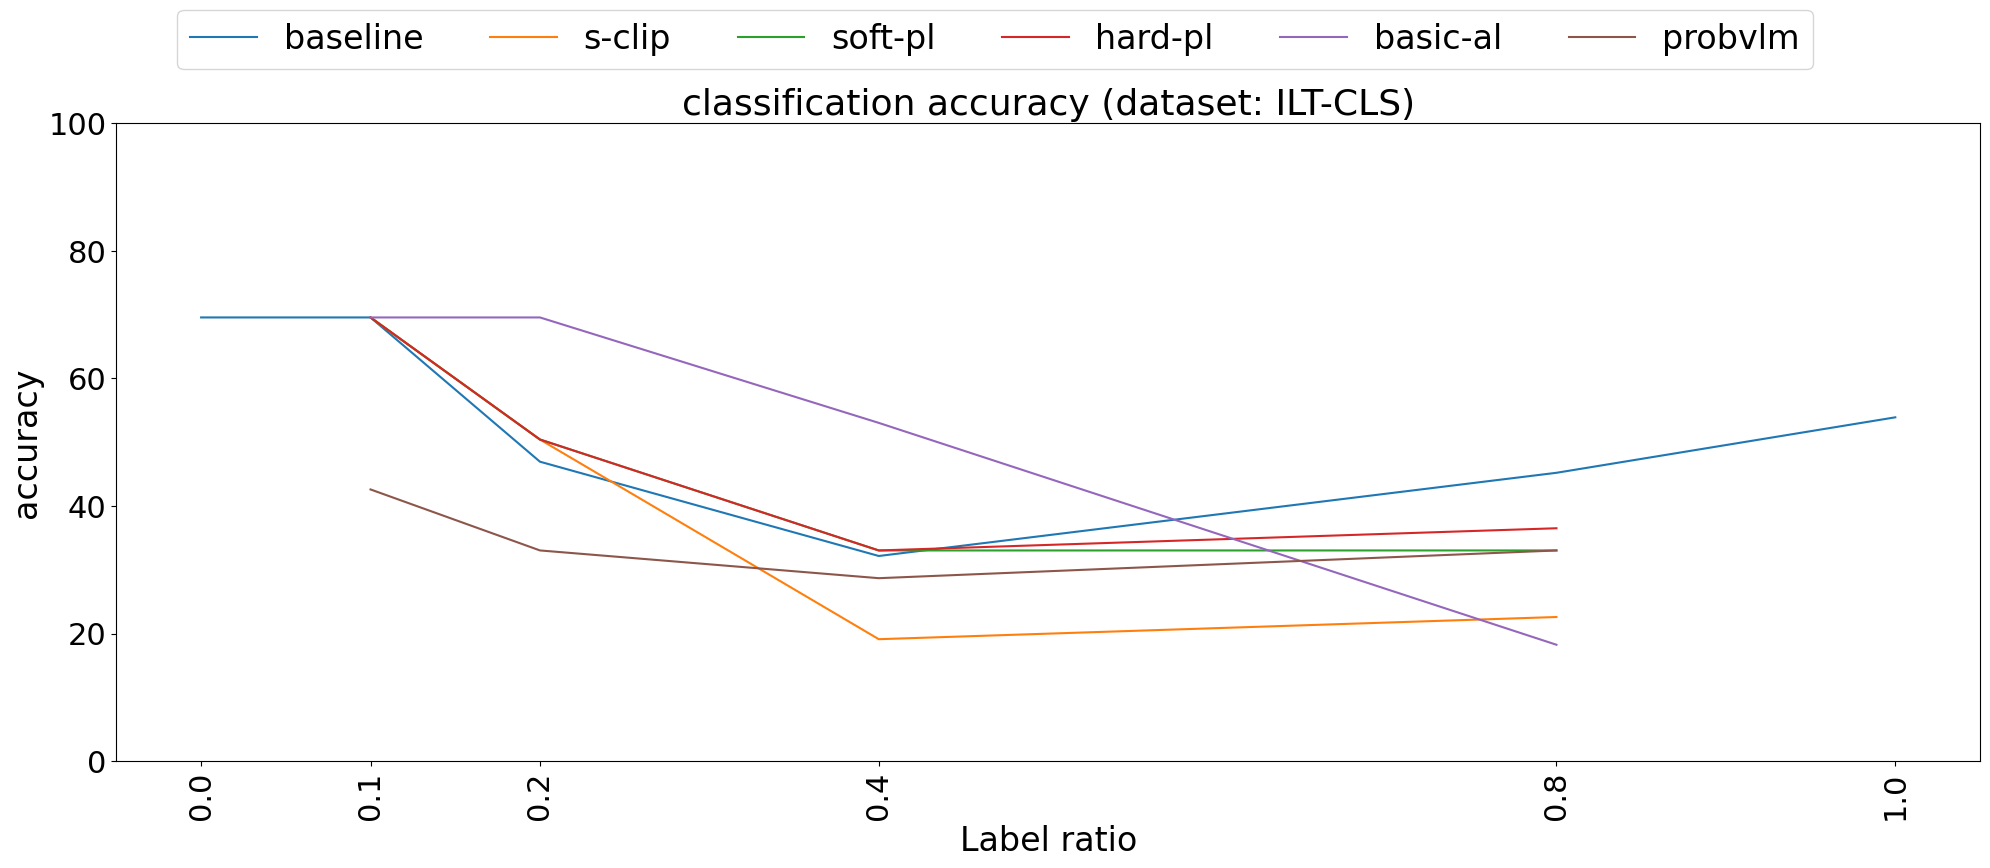

In [8]:
rows, cols = 1, 1
fig, axes = plt.subplots(rows, cols, figsize = (20, 8))

row, col = 0, 0
for metric in zeroshot_metrics:
    for dataset in zeroshot_datasets:
#         print(dataset, metric)
        label = row == 0 and col == 0 # only assign a legend label for the first subplot (prevents duplicates)
        plot_model_comparison(results_dict, metric, dataset, ax = axes, label = label, epochs_dict = epochs_dict, 
                              base_fontsize = base_fontsize, confidence_band_type = '', display_table_results = True, table_label_ratio = 0.2)
        col += 1
        if col == cols:
            col = 0
            row += 1
fig.legend(loc='upper center', ncol=6, fancybox=True, bbox_to_anchor=(0.5, 1.1), fontsize = base_fontsize)
plt.tight_layout()
plt.savefig('./results/ILT-CLS_accuracy.pdf', transparent = True, bbox_inches='tight')
plt.show()

baseline image_to_text_R@1 ILT
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
s-clip image_to_text_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
soft-pl image_to_text_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
hard-pl image_to_text_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
basic-al image_to_text_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
0,baseline vs s-clip,ILT,image_to_text_R@1,423.0,0.013,True
8,s-clip vs probvlm,ILT,image_to_text_R@1,73.5,0.001,True
11,soft-pl vs probvlm,ILT,image_to_text_R@1,105.0,0.009,True
13,hard-pl vs probvlm,ILT,image_to_text_R@1,104.5,0.009,True
14,basic-al vs probvlm,ILT,image_to_text_R@1,129.0,0.048,True


baseline text_to_image_R@1 ILT
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
s-clip text_to_image_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
soft-pl text_to_image_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
hard-pl text_to_image_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
basic-al text_to_image_R@1 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
1,baseline vs soft-pl,ILT,text_to_image_R@1,153.0,0.003,True
2,baseline vs hard-pl,ILT,text_to_image_R@1,177.5,0.012,True
4,baseline vs probvlm,ILT,text_to_image_R@1,188.5,0.025,True


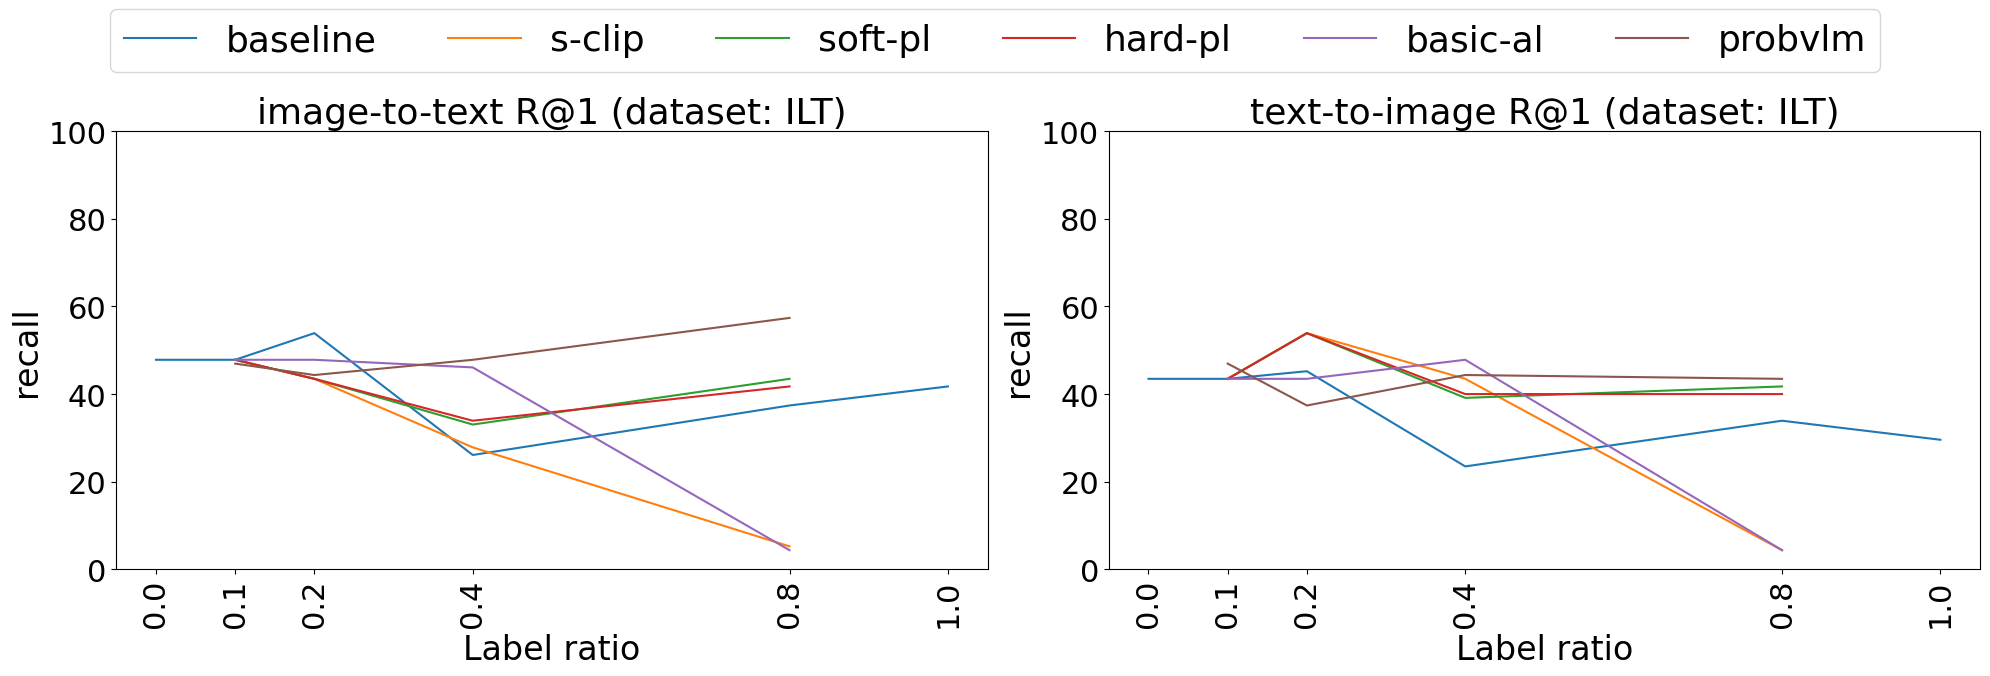

In [9]:
plot_recall_model_comparison(results_dict, retrieval_metrics, retrieval_datasets, base_fontsize = base_fontsize, k = 1, 
                            confidence_band_type = '', epochs_dict = epochs_dict, display_table_results = True)
plt.savefig('./results/ILT_recall_1.pdf', transparent = True, bbox_inches='tight')
plt.show()

baseline image_to_text_R@5 ILT
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
s-clip image_to_text_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
soft-pl image_to_text_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
hard-pl image_to_text_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
basic-al image_to_text_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
0,baseline vs s-clip,ILT,image_to_text_R@5,417.0,0.017,True
7,s-clip vs basic-al,ILT,image_to_text_R@5,125.0,0.031,True
14,basic-al vs probvlm,ILT,image_to_text_R@5,300.0,0.006,True


baseline text_to_image_R@5 ILT
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
s-clip text_to_image_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
soft-pl text_to_image_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
hard-pl text_to_image_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
basic-al text_to_image_R@5 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?


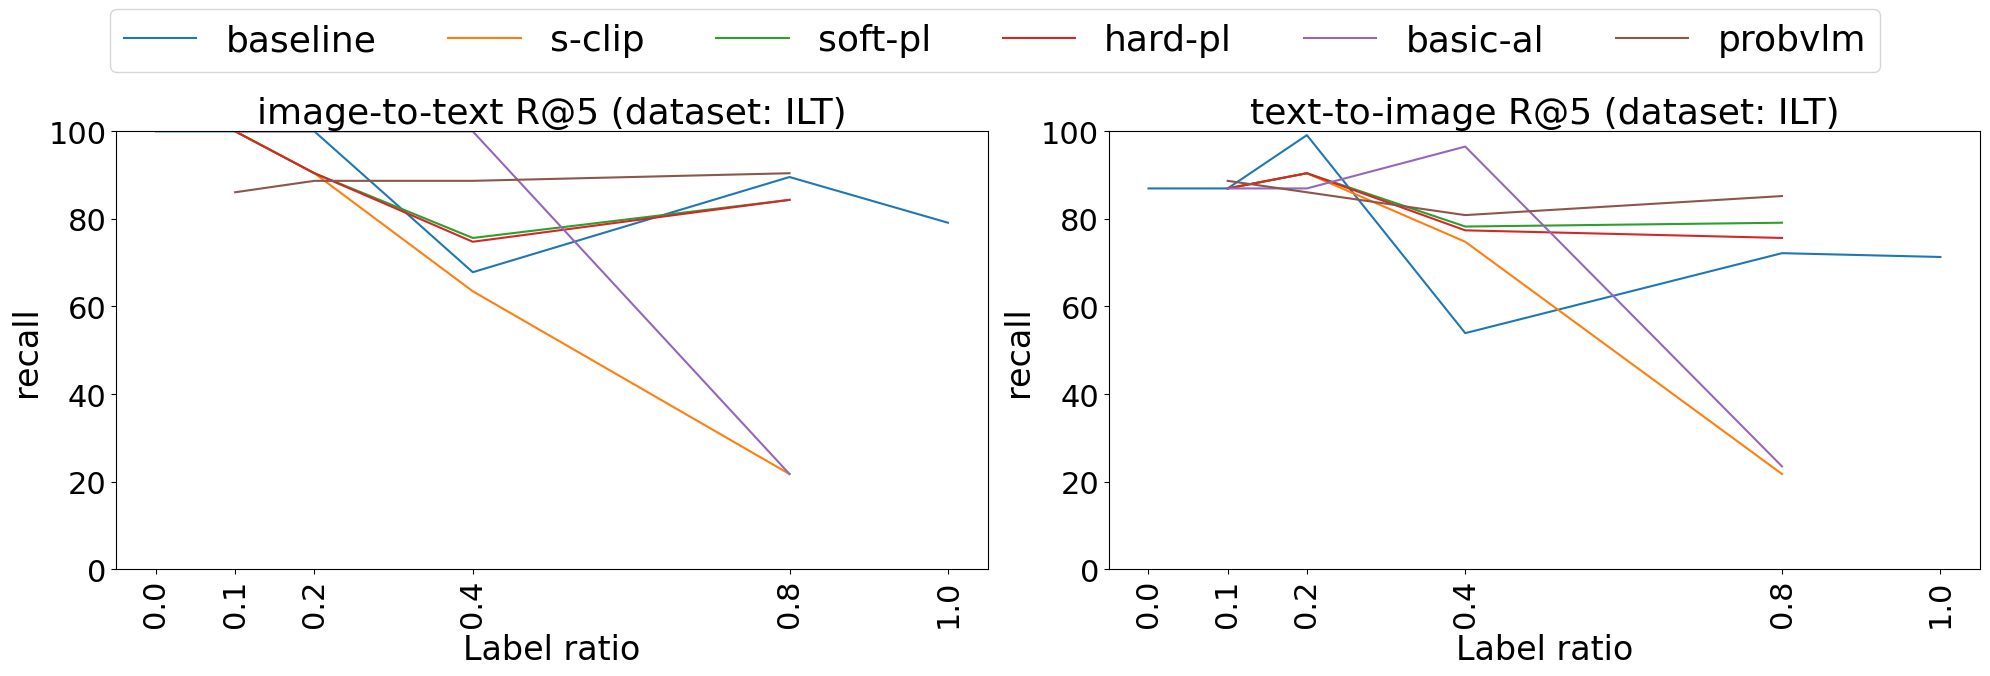

In [10]:
plot_recall_model_comparison(results_dict, retrieval_metrics, retrieval_datasets, base_fontsize = base_fontsize, k = 5,
                            confidence_band_type = '', epochs_dict = epochs_dict, display_table_results = True)
plt.savefig('./results/ILT_recall_5.pdf', transparent = True, bbox_inches='tight')
plt.show()

baseline image_to_text_R@10 ILT
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
s-clip image_to_text_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
soft-pl image_to_text_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
hard-pl image_to_text_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
basic-al image_to_text_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\p

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
6,s-clip vs hard-pl,ILT,image_to_text_R@10,133.0,0.042,True


baseline text_to_image_R@10 ILT
0.0
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
1.0
29.56 $\pm$ 11.26 & 71.31 $\pm$ 4.95 & 90.43 $\pm$ 3.63 & 41.74 $\pm$ 16.44 & 79.13 $\pm$ 9.42 & 93.91 $\pm$ 2.38 & 53.91 $\pm$ 12.9
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
s-clip text_to_image_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
soft-pl text_to_image_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
hard-pl text_to_image_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 69.57 $\pm$ 0.0
basic-al text_to_image_R@10 ILT
0.1
43.48 $\pm$ 0.0 & 86.96 $\pm$ 0.0 & 100.0 $\pm$ 0.0 & 47.83 $\p

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?


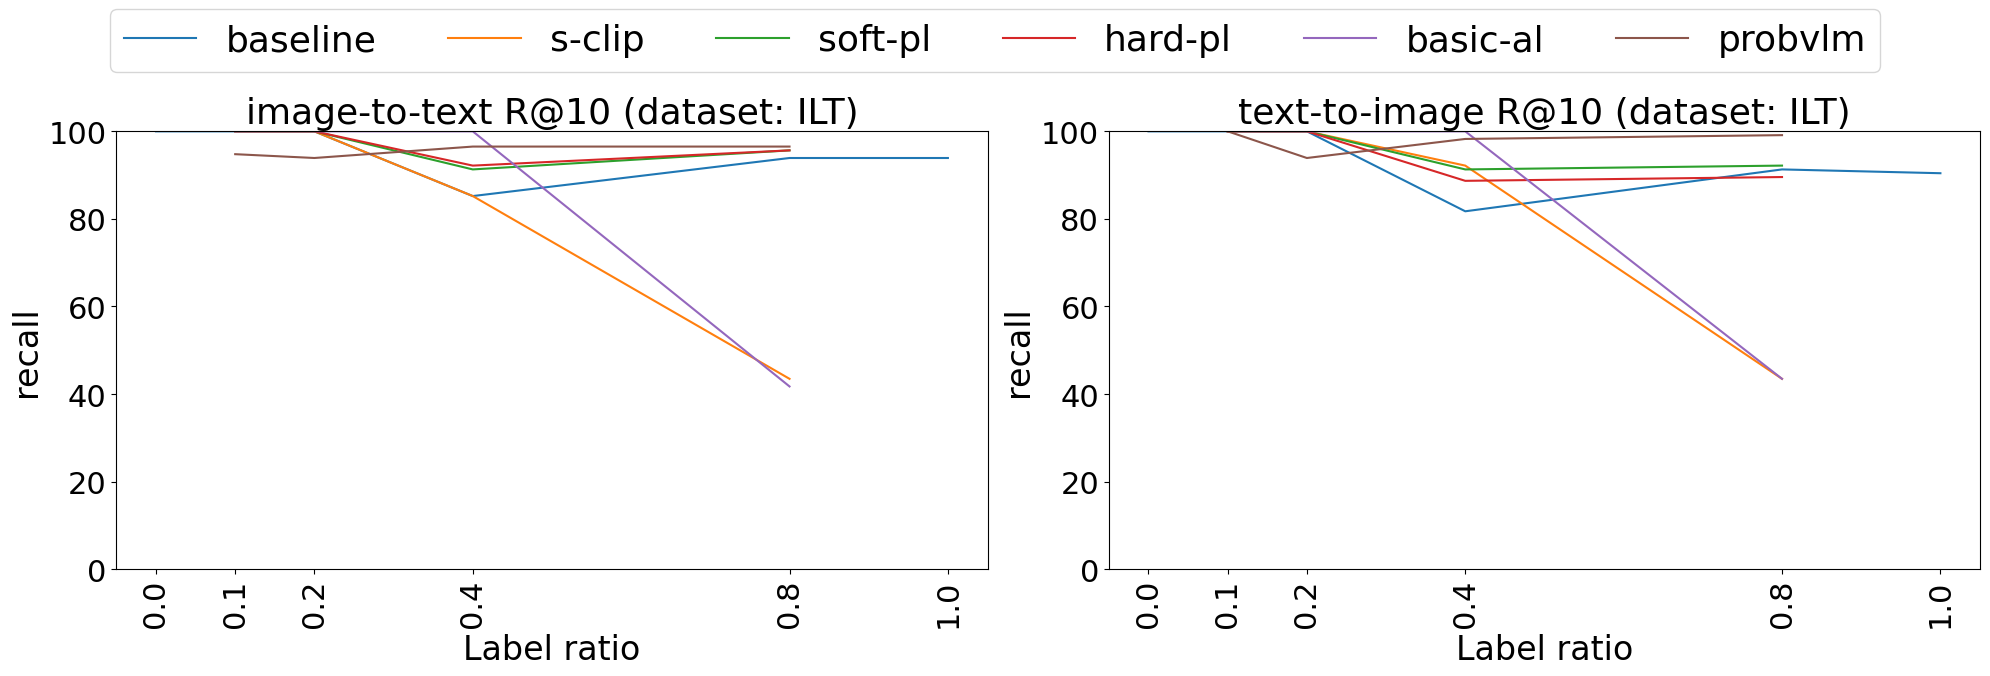

In [11]:
plot_recall_model_comparison(results_dict, retrieval_metrics, retrieval_datasets, base_fontsize = base_fontsize, k = 10,
                            confidence_band_type = '', epochs_dict = epochs_dict, display_table_results = True)
plt.savefig('./results/ILT_recall_10.pdf', transparent = True, bbox_inches='tight')
plt.show()